# CUIモードになっているか確認

CUIモードになるとよりメモリを確保した処理が可能なので下記のコマンドで設定します。再起動するので再度、ログインしてください。


```
sudo systemctl set-default multi-user.target
sudo reboot
```

アクセスするにはJetsonとネットワークが同一もしくは有線接続されたPCが必要になります。下記のコマンドで`jupyter-lab`を起動します。

```
jupyter-lab --ip 0.0.0.0
```

# 学習済みモデルの取得

TensorFlowのgithubに学習済みモデルが提供されているので、そこからモデルを取得します。

In [9]:
import requests
import tarfile
import os

ssd_faster_net = 'http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz'
ssd_model_name = os.path.basename(ssd_faster_net)
resplace_ssd_model_name = ssd_model_name.replace('.tar.gz', '')

r = requests.get(ssd_faster_net)

with open('./' + ssd_model_name, 'wb') as f:  
    f.write(r.content)

with tarfile.open(ssd_model_name, 'r:gz') as tf:
    tf.extractall(path='./')


モデルのノードを下記コマンドで確認できます。入力ノード数、出力ノード数が確認できます。

In [9]:
! saved_model_cli show --all --dir ./ssdlite_mobilenet_v2_coco_2018_05_09/saved_model

2020-05-18 20:11:27.339872: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2020-05-18 20:11:30.164472: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer.so.7
2020-05-18 20:11:30.169877: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer_plugin.so.7

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_UINT8
        shape: (-1, -1, -1, 3)
        name: image_tensor:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['detection_boxes'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100, 4)
        name: detection_boxes:0
    outputs['detection_classes'] tensor_info:
        dtype: DT_F

必要なライブラリをインポートします。TensorFlow2.0系では、デフォルトでTensorFlow Eager modeが設定されているため、これをオフにします。モデルの柔軟性よりも速度を重視しているため、この設定にします。

In [1]:
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.python.client import timeline

%matplotlib inline

物体検出のテスト用画像を取得します。

In [ ]:
! git clone https://github.com/NVIDIA-AI-IOT/tf_trt_models.git

どのような画像を取得できたかを確認します。また画像をリサイズし画像のデータフォーマットをnumpy形式にします。

In [ ]:
IMAGE_PATH = './tf_trt_models/examples/detection/data/huskies.jpg'
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = image.resize((300, 300))

image_resized = np.asarray(image_resized)

batch_size = 1
image_resized_array = np.zeros((batch_size, 300, 300, 3), dtype=np.float32)

for i in range(batch_size):
    image_resized_array[i, :] = image_resized

In [ ]:
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

この処理はTensorFlowはデフォルトで100%のGPUメモリを確保するため、必要なメモリのみ確保するための処理です。

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

下記のコードでTensorFlowのグラフの情報からキーの情報を取得します。

キーに付随するValueがtf.TensorInfoとインスタンスの種類が同一の場合、グラフからtensor名を取得して辞書に設定しています。

この関数は入力と出力のTensor名をグラフから取得するための関数になります。

In [5]:
import tensorflow as tf
import numpy as np

def extract_tensors(signature_def, graph):
    output = dict()

    for key in signature_def:
        value = signature_def[key]

        if isinstance(value, tf.TensorInfo):
            output[key] = graph.get_tensor_by_name(value.name)

    return output

TensorFlowのグラフから入力のTensorのキーを取得します。

In [6]:
def extract_input_name(signature_def, graph):
    input_tensors = extract_tensors(signature_def["serving_default"].inputs, graph)
    #Assuming one input in model.
    key = list(input_tensors.keys())[0]
    return input_tensors.get(key).name

TensorFlowのグラフから出力のTensorのキーを取得します。

入力と違う点は出力が物体検出数、物体検出クラス、物体検出スコア、物体検出の位置の4つの情報が出力され、複数あるため、下記のような実装になります。

In [7]:
def extract_output_name(signature_def, graph):
    output_tensors = extract_tensors(signature_def["serving_default"].outputs, graph)
    #Assuming one output in model.
    output_names = []
    for key in output_tensors.keys():
        print(key)
        output_names.append(output_tensors.get(key).name)
    return output_names

下記のコードで保存したモデルをsaved_model形式で取得し、入力、出力のテンソール名を取得したあとに推論処理を行っています。

この推論処理の初期の処理はcuDNNのGPUリソースを確保するため、時間がかかるのでベンチマークを取る場合は複数回実行してからベンチマークを取っています。
- https://docs.nvidia.com/deeplearning/sdk/cudnn-api/index.html#cudnnCreate

初回の処理時間は遅いので2回目の推論時間をベンチマーク時間として使用してください。

In [14]:
input_saved_model = './ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/'
    
with tf.Session(graph=tf.Graph()) as session:
    serve = tf.saved_model.load(session, tags=[tf.saved_model.tag_constants.SERVING], export_dir=input_saved_model)

    input_tensor_name = extract_input_name(serve.signature_def, session.graph)
    output_tensor_name_list = extract_output_name(serve.signature_def, session.graph)

    result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: image_resized_array},
                             options=run_options,
                             run_metadata=run_metadata
                            )
    start = time.time()
    
    for i in range(30):
        result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: image_resized_array},
                            )

    t = time.time() - start
    print('estmate time:', t)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
detection_classes
num_detections
detection_boxes
detection_scores
estmate time: 3.075101137161255


GPUとCOUの使用率を見るためのメタ情報を取得します。

In [9]:
input_saved_model = './ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/'
    
with tf.Session(graph=tf.Graph()) as session:
    serve = tf.saved_model.load(session, tags=[tf.saved_model.tag_constants.SERVING], export_dir=input_saved_model)

    input_tensor_name = extract_input_name(serve.signature_def, session.graph)
    output_tensor_name_list = extract_output_name(serve.signature_def, session.graph)

    result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: image_resized_array},
                             options=run_options,
                             run_metadata=run_metadata
                            )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
detection_classes
num_detections
detection_boxes
detection_scores


tensorflowのCPUとGPUの使用率を把握するために下記のコードでjsonファイルを作成します。

In [15]:
step_stats = run_metadata.step_stats
tl = timeline.Timeline(step_stats)

ctf = tl.generate_chrome_trace_format(show_memory=False,
                                      show_dataflow=True)

with open("timeline_tf.json", "w") as f:
    f.write(ctf)

今回はCOCOのデータ・セットで学習済みのモデルを使用しているため、各クラスの情報を設定します。

In [16]:
classes_90 = ["background", "person", "bicycle", "car", "motorcycle",
            "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
            "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
            "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
            "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
            "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
            "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
            "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
            "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
            "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
            "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
            "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush" ]

推論結果を取得します。

In [17]:
classes = result[0][0]
num_detections = result[1][0]
boxes = result[2][0]
scores = result[3][0]

下記のコードで物体検出の結果を表示します。

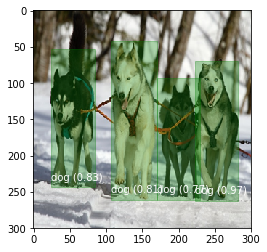

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image_resized)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    # scale box to image coordinates
    box = boxes[i] * np.array([image_resized_array.shape[1], image_resized_array.shape[1], 
                               image_resized_array.shape[1], image_resized_array.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1], y=box[2] - 10, s='%s (%0.2f) ' % (classes_90[int(classes[i])], scores[i]), color='w')

plt.show()

# TF-TRT FP32

ここからはTF-TRTでモデルを最適化する方法とその結果を確認します。

TensorFlowのグラフをリセットするためにnotebookを一旦、止めます。

In [ ]:
import os
os.kill(os.getpid(), 9)

先程と同様に画像の前処理と画像を確認します。TensorFlow Eager modeはオフにします。

`TF_CPP_VMODULE`でTensorRTの変換ログを確認するための設定を行います。

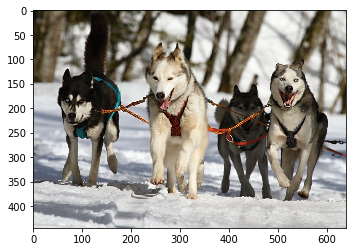

In [1]:
import os

os.environ['TF_CPP_VMODULE'] = 'segment=2,convert_graph=2,convert_nodes=2,trt_engine=1,trt_logger=2'

from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.python.client import timeline

%matplotlib inline

IMAGE_PATH = './tf_trt_models/examples/detection/data/huskies.jpg'
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = image.resize((300, 300))

image_resized = np.asarray(image_resized)

batch_size = 1
image_resized_array = np.zeros((batch_size, 300, 300, 3), dtype=np.float32)

for i in range(batch_size):
    image_resized_array[i, :] = image_resized

Deep LearningのForward処理のCPUとGPU使用率を検証するため、下記の設定をします。

In [2]:
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

先程と同様に必要なメモリのみ確保するための処理を実行します。

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


ここでTensorRTに使用するメモリのサイズを除いた分までしかTensorFlowがメモリ確保できないように設定します。

詳細は[こちら](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html#mem-manage)をご覧ください。


In [4]:
# Jetson Xavier memory size: 16280 * 1000 * 1000  
gpu_memory = (16280 * 1000 * 1000)
max_workspace_size = int(gpu_memory * 0.6)

tensorflow_gpu_memory = int(gpu_memory - max_workspace_size)
tensorflow_gpu_memory

6512000000

先程のコードで設定したTensorFlowのメモリサイズを設定します。

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=tensorflow_gpu_memory)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


FP32の予測精度でモデルを最適化します。先程設定した`max_workspace_size`でTensorRTが使用するGPUメモリの最大サイズを設定します。

TF-TRTによるモデルの最適化はフローズングラフ形式とSaved Model形式がありますがフローズングラフ形式はTensorFlow2系では使用できず、

アウトプットノードの情報が必要になるため、今回はSaved Model形式を採用しています。

In [6]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import os
import shutil

input_saved_model = './ssdlite_mobilenet_v2_coco_2018_05_09/saved_model'
output_saved_model_dir = "./export_trt_dir"
if os.path.exists(output_saved_model_dir):
    shutil.rmtree(output_saved_model_dir)

converter = trt.TrtGraphConverter(
    input_saved_model_dir=input_saved_model, 
    precision_mode='FP32',
    max_workspace_size_bytes=max_workspace_size,
)

converter.convert()
converter.save(output_saved_model_dir)

INFO:tensorflow:Linked TensorRT version: (7, 1, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 1, 0)
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./export_trt_dir/saved_model.pb


TF-TRTの良さはTensorFlowのAPIを変更せずに予測できる点にあります。先程と同一のコードで推論処理が可能なため同一の関数を設定します。

In [7]:
import tensorflow as tf
import numpy as np

def extract_tensors(signature_def, graph):
    output = dict()

    for key in signature_def:
        value = signature_def[key]

        if isinstance(value, tf.TensorInfo):
            output[key] = graph.get_tensor_by_name(value.name)

    return output

def extract_input_name(signature_def, graph):
    input_tensors = extract_tensors(signature_def["serving_default"].inputs, graph)
    #Assuming one input in model.
    key = list(input_tensors.keys())[0]
    return input_tensors.get(key).name

def extract_output_name(signature_def, graph):
    output_tensors = extract_tensors(signature_def["serving_default"].outputs, graph)
    #Assuming one output in model.
    output_names = []
    for key in output_tensors.keys():
        print(key)
        output_names.append(output_tensors.get(key).name)
    return output_names

先程と同一のコードで推論処理が可能です。速度は約2倍程度、高速化します。

In [8]:
with tf.Session(graph=tf.Graph()) as session:
    serve = tf.saved_model.load(session, tags=[tf.saved_model.tag_constants.SERVING], export_dir=output_saved_model_dir)

    input_tensor_name = extract_input_name(serve.signature_def, session.graph)
    output_tensor_name_list = extract_output_name(serve.signature_def, session.graph)

    result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: image_resized_array},
                             options=run_options,
                             run_metadata=run_metadata
                            )   
    start = time.time()
    
    for i in range(30):
        result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: image_resized_array},
                            )

    t = time.time() - start
    print('estmate time:', t)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
detection_boxes
detection_classes
detection_scores
num_detections
estmate time: 2.8702354431152344


下記のリンクに作成されたjsonファイルを読み込ませることででDeep Learningの処理でGPUとCPUの使用率のタイムラインが確認可能です。

`chrome://tracing/`

In [14]:
step_stats = run_metadata.step_stats
tl = timeline.Timeline(step_stats)

ctf = tl.generate_chrome_trace_format(show_memory=False,
                                      show_dataflow=True)

with open("timeline_tf_trt_fp32.json", "w") as f:
    f.write(ctf)

ここからはTF-TRTによる最適化を行ってもモデルの性能が変わらないかを確認します。ほぼ同一の結果になっていることを確認します。

先程の推論結果の確認のコードと同一のため、説明は省略します。

In [11]:
classes_90 = ["background", "person", "bicycle", "car", "motorcycle",
            "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
            "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
            "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
            "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
            "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
            "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
            "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
            "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
            "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
            "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
            "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush" ]

In [12]:
boxes = result[0][0]
classes = result[1][0]
scores = result[2][0]
num_detections = result[3][0]

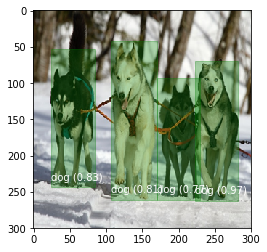

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image_resized)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    # scale box to image coordinates
    box = boxes[i] * np.array([image_resized_array.shape[1], image_resized_array.shape[1], 
                               image_resized_array.shape[1], image_resized_array.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1], y=box[2] - 10, s='%s (%0.2f) ' % (classes_90[int(classes[i])], scores[i]), color='w')

plt.show()

# TF-TRT FP16

ここからはTF-TRTでモデルを最適化する方法と予測精度をFP16に変えて、その結果を確認します。

TensorFlowのグラフをリセットするためにnotebookを一旦、止めます。

In [ ]:
import os
os.kill(os.getpid(), 9)

先程と同様に画像の前処理と画像を確認します。TensorFlow Eager modeはオフにします。

`TF_CPP_VMODULE`でTensorRTの変換ログを確認するための設定を行います。

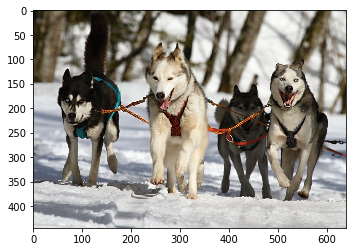

In [1]:
import os

os.environ['TF_CPP_VMODULE'] = 'segment=2,convert_graph=2,convert_nodes=2,trt_engine=1,trt_logger=2'
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.python.client import timeline

%matplotlib inline

IMAGE_PATH = './tf_trt_models/examples/detection/data/huskies.jpg'
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = image.resize((300, 300))

image_resized = np.asarray(image_resized)

batch_size = 1
image_resized_array = np.zeros((batch_size, 300, 300, 3), dtype=np.float32)

for i in range(batch_size):
    image_resized_array[i, :] = image_resized

Deep LearningのForward処理のCPUとGPU使用率を検証するため、下記の設定をします。

In [2]:
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

先程と同様に必要なメモリのみ確保するための処理を実行します。

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


先程と同様にここでTensorRTに使用するメモリのサイズを除いた分までしかTensorFlowがメモリ確保できないように設定します。

詳細は[こちら](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html#mem-manage)をご覧ください。


In [4]:
# Jetson Xavier memory size: 16280 * 1000 * 1000  
gpu_memory = (16280 * 1000 * 1000)
max_workspace_size = int(gpu_memory * 0.6)

tensorflow_gpu_memory = int(gpu_memory - max_workspace_size)
tensorflow_gpu_memory

6512000000

先程のコードで設定したTensorFlowのメモリサイズを設定します。

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=tensorflow_gpu_memory)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


FP16の予測精度でモデルを最適化します。先程設定した`max_workspace_size`でTensorRTが使用するGPUメモリの最大サイズを設定します。

TF-TRTによるモデルの最適化はフローズングラフ形式とSaved Model形式がありますがフローズングラフ形式はTensorFlow2系では使用できず、

アウトプットノードの情報が必要になるため、今回はSaved Model形式を採用しています。

In [6]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import os
import shutil

input_saved_model = './ssdlite_mobilenet_v2_coco_2018_05_09/saved_model'
output_saved_model_dir = "./export_trt_dir_FP16"
if os.path.exists(output_saved_model_dir):
    shutil.rmtree(output_saved_model_dir)

converter = trt.TrtGraphConverter(
    input_saved_model_dir=input_saved_model, 
    precision_mode='FP16',
    max_workspace_size_bytes=max_workspace_size,
)

converter.convert()
converter.save(output_saved_model_dir)

INFO:tensorflow:Linked TensorRT version: (7, 1, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 1, 0)
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./export_trt_dir_FP16/saved_model.pb


先程と同一のコードで推論処理が可能なため同一の関数を設定します。

In [7]:
import tensorflow as tf
import numpy as np

def extract_tensors(signature_def, graph):
    output = dict()

    for key in signature_def:
        value = signature_def[key]

        if isinstance(value, tf.TensorInfo):
            output[key] = graph.get_tensor_by_name(value.name)

    return output

def extract_input_name(signature_def, graph):
    input_tensors = extract_tensors(signature_def["serving_default"].inputs, graph)
    #Assuming one input in model.
    key = list(input_tensors.keys())[0]
    print(key)
    return input_tensors.get(key).name

def extract_output_name(signature_def, graph):
    output_tensors = extract_tensors(signature_def["serving_default"].outputs, graph)
    #Assuming one output in model.
    output_names = []
    for key in output_tensors.keys():
        print(key)
        output_names.append(output_tensors.get(key).name)
    return output_names

先程と同一のコードで推論処理が可能です。速度は約2倍程度、高速化します。

In [8]:
with tf.Session(graph=tf.Graph()) as session:
    serve = tf.saved_model.load(session, tags=[tf.saved_model.tag_constants.SERVING], export_dir=output_saved_model_dir)

    input_tensor_name = extract_input_name(serve.signature_def, session.graph)
    output_tensor_name_list = extract_output_name(serve.signature_def, session.graph)

    result = session.run(output_tensor_name_list, 
                     feed_dict={input_tensor_name: image_resized_array},
                     options=run_options,
                     run_metadata=run_metadata
                    )
    
    start = time.time()
    
    for i in range(30):
        result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: image_resized_array},
                            )

    t = time.time() - start
    print('second estmate time:', t)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
inputs
detection_boxes
detection_classes
detection_scores
num_detections
second estmate time: 2.712573766708374



下記のリンクに作成されたjsonファイルを読み込ませることででDeep Learningの処理でGPUとCPUの使用率のタイムラインが確認可能です。

`chrome://tracing/`

遅くなっている場合はTensorRTへの変換ができていない可能性があります。

その場合は下記のjsonファイルを確認して変換できているか確認お願いします。

In [9]:
step_stats = run_metadata.step_stats
tl = timeline.Timeline(step_stats)

ctf = tl.generate_chrome_trace_format(show_memory=False,
                                      show_dataflow=True)

with open("timeline_tf_trt_fp16.json", "w") as f:
    f.write(ctf)

ここからはTF-TRTによる最適化を行ってもモデルの性能が変わらないかを確認します。ほぼ同一の結果になっていることを確認します。

先程の推論結果の確認のコードと同一のため、説明は省略します。

In [10]:
classes_90 = ["background", "person", "bicycle", "car", "motorcycle",
            "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
            "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
            "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
            "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
            "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
            "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
            "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
            "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
            "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
            "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
            "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush" ]

In [11]:
boxes = result[0][0]
classes = result[1][0]
scores = result[2][0]
num_detections = result[3][0]

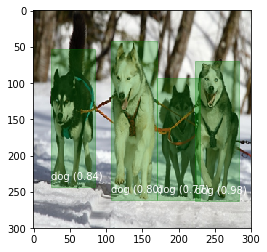

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image_resized)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    # scale box to image coordinates
    box = boxes[i] * np.array([image_resized_array.shape[1], image_resized_array.shape[1], 
                               image_resized_array.shape[1], image_resized_array.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1], y=box[2] - 10, s='%s (%0.2f) ' % (classes_90[int(classes[i])], scores[i]), color='w')

plt.show()

# TF-TRT Int8

ここからはTF-TRTでモデルを予測精度INT8で最適化する方法とその結果を確認します。

TensorFlowのグラフをリセットするためにnotebookを一旦、止めます。

In [ ]:
import os
os.kill(os.getpid(), 9)

先程と同様に画像の前処理と画像を確認します。TensorFlow Eager modeはオフにします。

`TF_CPP_VMODULE`でTensorRTの変換ログを確認するための設定を行います。

In [1]:
import os

os.environ['TF_CPP_VMODULE'] = 'segment=2,convert_graph=2,convert_nodes=2,trt_engine=1,trt_logger=2'
import numpy as np
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from PIL import Image

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


先程と同様に必要なメモリのみ確保するための処理を実行します。

In [2]:
# Jetson Xavier memory size: 16280 * 1000 * 1000  
gpu_memory = (16280 * 1000 * 1000)
max_workspace_size = int(gpu_memory * 0.6)

tensorflow_gpu_memory = int(gpu_memory - max_workspace_size)
tensorflow_gpu_memory

6512000000

ここでTensorRTに使用するメモリのサイズを除いた分までしかTensorFlowがメモリ確保できないように設定します。

詳細は[こちら](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html#mem-manage)をご覧ください。

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=tensorflow_gpu_memory)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


INT8では活性化関数の適切な閾値を設定するためのキャリブレーションデータを返す関数を設定します。

In [4]:
def my_calib_data():
    IMAGE_PATH = './tf_trt_models/examples/detection/data/huskies.jpg'
    image = Image.open(IMAGE_PATH)

    image_resized = image.resize((300, 300))

    image_resized_array = np.asarray(image_resized)
    return [image_resized_array]

INT8の予測精度でモデルを最適化します。先程設定した`max_workspace_size`でTensorRTが使用するGPUメモリの最大サイズを設定します。

TF-TRTによるモデルの最適化はフローズングラフ形式とSaved Model形式がありますがフローズングラフ形式はTensorFlow2系では使用できず、

アウトプットノードの情報が必要になるため、今回はSaved Model形式を採用しています。

In [5]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import os
import shutil

input_saved_model = './ssdlite_mobilenet_v2_coco_2018_05_09/saved_model'
output_saved_model_dir = "./export_trt_dir_INT8"
if os.path.exists(output_saved_model_dir):
    shutil.rmtree(output_saved_model_dir)

converter = trt.TrtGraphConverter(
    input_saved_model_dir=input_saved_model, 
    precision_mode='INT8',
    max_workspace_size_bytes=max_workspace_size
)

converter.convert()

converter.calibrate(
    fetch_names=["detection_boxes", "detection_classes", "detection_scores", "num_detections"],
    num_runs=10,
    feed_dict_fn=lambda: {'image_tensor:0': my_calib_data()}
)

converter.save(output_saved_model_dir)

INFO:tensorflow:Linked TensorRT version: (7, 1, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 1, 0)
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./export_trt_dir_INT8/saved_model.pb


メモリの都合上、推論前に一旦、Notebookをオフにします。

In [ ]:
import os
os.kill(os.getpid(), 9)

推論用の画像を設定します。コードはFP16のときと同様です。

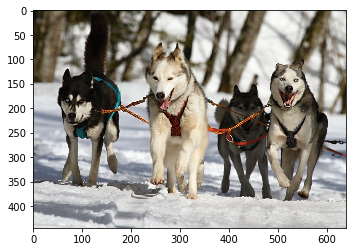

In [1]:
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
import tensorflow as tf
from tensorflow.python.client import timeline

tf.compat.v1.disable_eager_execution()
%matplotlib inline

IMAGE_PATH = './tf_trt_models/examples/detection/data/huskies.jpg'
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = image.resize((300, 300))

image_resized_array = np.asarray(image_resized)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Jetson Xavier memory size: 16280 * 1000 * 1000  
gpu_memory = (16280 * 1000 * 1000)
max_workspace_size = int(gpu_memory * 0.6)

tensorflow_gpu_memory = int(gpu_memory - max_workspace_size)
tensorflow_gpu_memory

6512000000

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=tensorflow_gpu_memory)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


Deep LearningのForward処理のCPUとGPU使用率を検証するため、下記の設定をします。

In [5]:
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

先程と同一のコードで推論処理が可能なため同一の関数を設定します。

In [6]:
def extract_tensors(signature_def, graph):
    output = dict()

    for key in signature_def:
        value = signature_def[key]

        if isinstance(value, tf.TensorInfo):
            output[key] = graph.get_tensor_by_name(value.name)

    return output

def extract_input_name(signature_def, graph):
    input_tensors = extract_tensors(signature_def["serving_default"].inputs, graph)
    #Assuming one input in model.
    key = list(input_tensors.keys())[0]
    return input_tensors.get(key).name

def extract_output_name(signature_def, graph):
    output_tensors = extract_tensors(signature_def["serving_default"].outputs, graph)
    #Assuming one output in model.
    output_names = []
    for key in output_tensors.keys():
        print(key)
        output_names.append(output_tensors.get(key).name)
    return output_names

先程と同一のコードで推論処理が可能です。速度は約2倍程度、高速化します。

In [7]:
output_saved_model_dir = "./export_trt_dir_INT8"
with tf.Session(graph=tf.Graph()) as session:
    serve = tf.saved_model.load(session, tags=[tf.saved_model.tag_constants.SERVING], export_dir=output_saved_model_dir)

    input_tensor_name = extract_input_name(serve.signature_def, session.graph)
    output_tensor_name_list = extract_output_name(serve.signature_def, session.graph)

    result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: [image_resized_array]},
                             options=run_options,
                             run_metadata=run_metadata
                            )
    
    start = time.time()
    
    for i in range(30):
        result = session.run(output_tensor_name_list, 
                             feed_dict={input_tensor_name: [image_resized_array]},
                            )

    t = time.time() - start
    print('second estmate time:', t)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
detection_boxes
detection_classes
detection_scores
num_detections
second estmate time: 2.630469560623169


下記のリンクに作成されたjsonファイルを読み込ませることででDeep Learningの処理でGPUとCPUの使用率のタイムラインが確認可能です。

`chrome://tracing/`

In [8]:
step_stats = run_metadata.step_stats
tl = timeline.Timeline(step_stats)

ctf = tl.generate_chrome_trace_format(show_memory=False,
                                      show_dataflow=True)

with open("timeline_tf_trt_int8.json", "w") as f:
    f.write(ctf)

ここからはTF-TRTによる最適化を行ってもモデルの性能が変わらないかを確認します。ほぼ同一の結果になっていることを確認します。

先程の推論結果の確認のコードと同一のため、説明は省略します。

In [9]:
classes_90 = ["background", "person", "bicycle", "car", "motorcycle",
            "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
            "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
            "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
            "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
            "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
            "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
            "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
            "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
            "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
            "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
            "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush" ]

In [10]:
boxes = result[0][0]
classes = result[1][0]
scores = result[2][0]
num_detections = result[3][0]

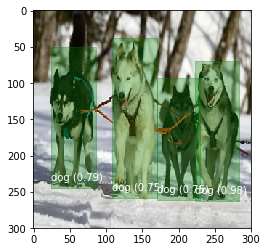

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image_resized)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    # scale box to image coordinates
    box = boxes[i] * np.array([image_resized_array.shape[0], image_resized_array.shape[1], 
                               image_resized_array.shape[0], image_resized_array.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1], y=box[2] - 10, s='%s (%0.2f) ' % (classes_90[int(classes[i])], scores[i]), color='w')

plt.show()

# グラフ変換前とTF-TRTグラフ変換後を確認

どのノードがTensorRTに変換されたかを確認するためにTensorboardを使用します。

最適化前のグラフを確認する方法は下記です。

```
tensorboard --logdir=graph --bind_all
```

最適化後のグラフを確認する方法は下記です。

FP32:

```
tensorboard --logdir=graph_trt --port 6007 --bind_all
```

FP16:

```
tensorboard --logdir=graph_trt_FP16 --port 6007 --bind_all
```

INT8:

```
tensorboard --logdir=graph_trt_INT8 --port 6007 --bind_all
```

In [6]:
import tensorflow as tf
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2

tf.compat.v1.reset_default_graph()
model_filename ='ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/saved_model.pb'
with tf.compat.v1.Session() as sess:
    with tf.compat.v1.gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        g_in = tf.compat.v1.import_graph_def(sm.meta_graphs[0].graph_def)
LOGDIR='graph'
train_writer = tf.compat.v1.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

Instructions for updating:
Use tf.gfile.GFile.


In [15]:
import tensorflow as tf
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2


tf.compat.v1.reset_default_graph()
model_filename ='./export_trt_dir/saved_model.pb'
with tf.compat.v1.Session() as sess:
    with tf.compat.v1.gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        g_in = tf.compat.v1.import_graph_def(sm.meta_graphs[0].graph_def)

LOGDIR='graph_trt'
train_writer = tf.compat.v1.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

Instructions for updating:
Use tf.gfile.GFile.


# TF-TRTグラフ(FP16)変換後を確認

In [16]:
import tensorflow as tf
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2


tf.compat.v1.reset_default_graph()
model_filename ='./export_trt_dir_FP16/saved_model.pb'
with tf.compat.v1.Session() as sess:
    with tf.compat.v1.gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        g_in = tf.compat.v1.import_graph_def(sm.meta_graphs[0].graph_def)

LOGDIR='graph_trt_FP16'
train_writer = tf.compat.v1.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

# TF-TRTグラフ(INT8)変換後を確認

In [17]:
import tensorflow as tf
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2


tf.compat.v1.reset_default_graph()
model_filename ='./export_trt_dir_INT8/saved_model.pb'
with tf.compat.v1.Session() as sess:
    with tf.compat.v1.gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        g_in = tf.compat.v1.import_graph_def(sm.meta_graphs[0].graph_def)

LOGDIR='graph_trt_INT8'
train_writer = tf.compat.v1.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)